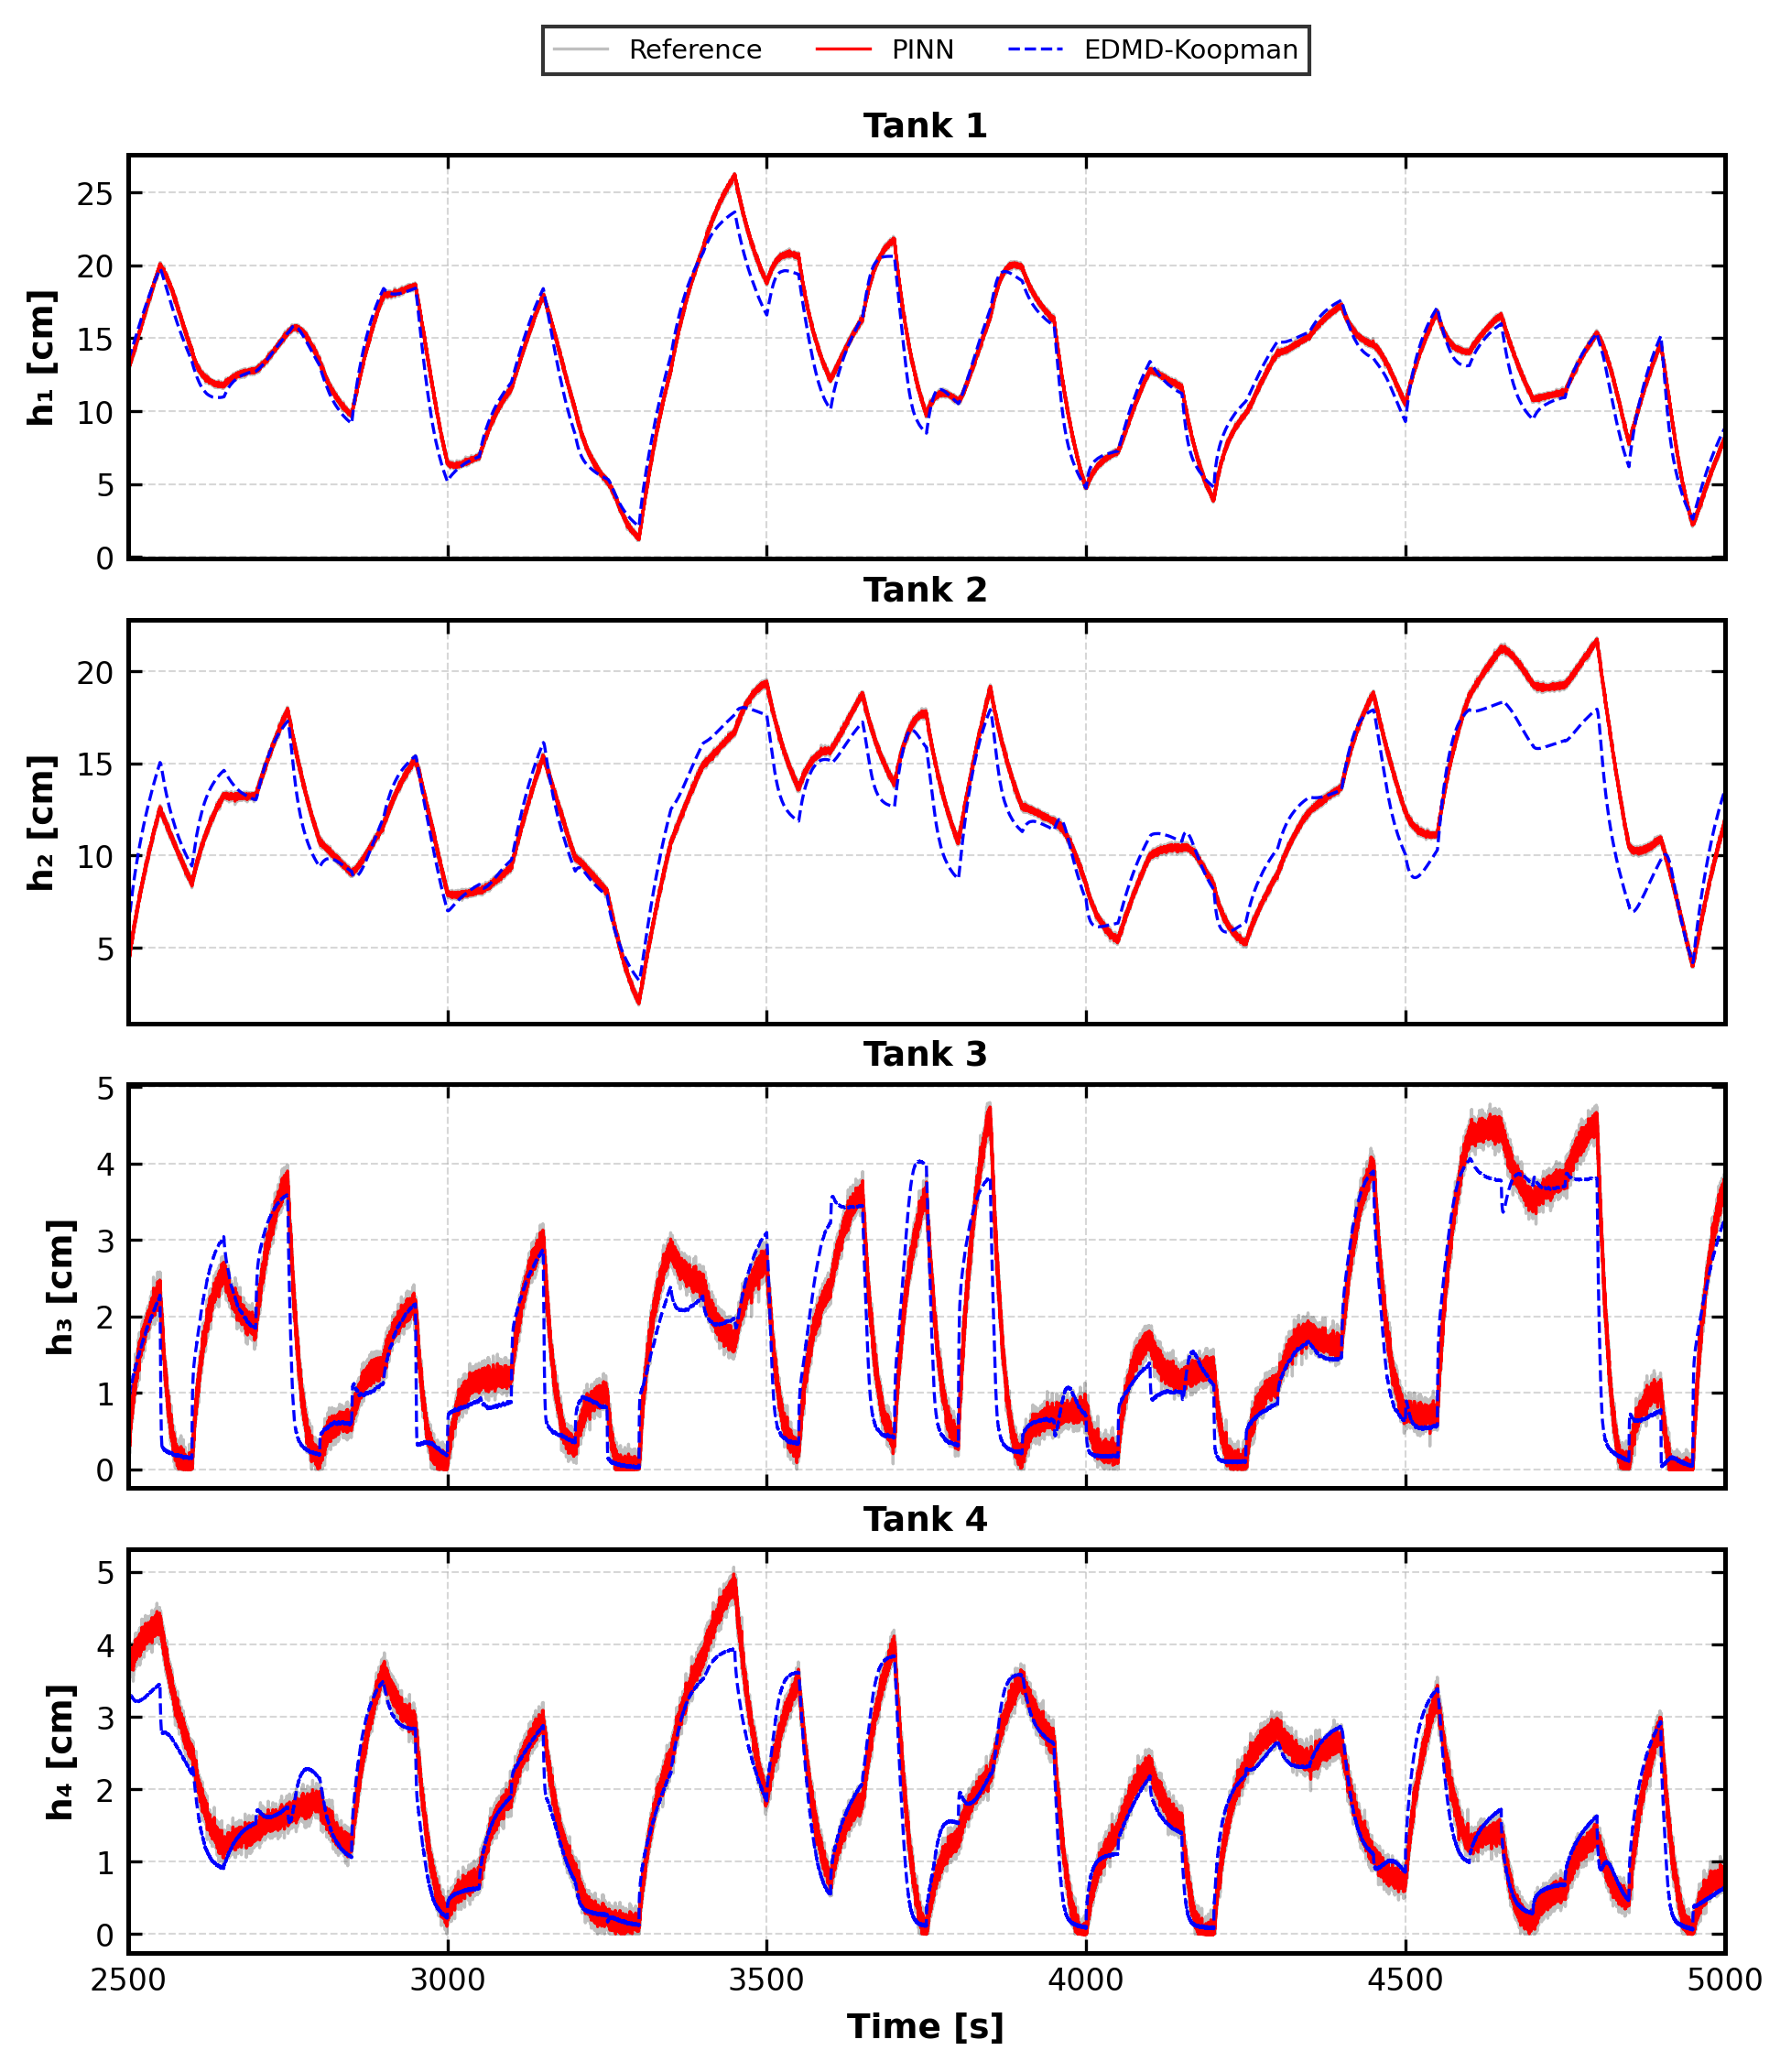

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. CARGA DE DATOS
df_k_inf = pd.read_csv('comparacion_koopman_tanques_inferiores.csv')
df_k_sup = pd.read_csv('comparacion_koopman_tanques_superiores.csv')
df_p_inf = pd.read_csv('comparacion_pinn_tanques_inferiores.csv')
df_p_sup = pd.read_csv('comparacion_pinn_tanques_superiores.csv')

# 2. CONFIGURACIÓN ESTILO IEEE / BOX-ENCASED
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.linewidth": 1.2,      # Bordes de la caja más gruesos para elegancia
    "legend.fontsize": 7,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "lines.linewidth": 1.1
})

# Ajustamos el tamaño: más ancho para que parezca "box" como en la referencia
fig, axs = plt.subplots(4, 1, figsize=(7.5, 8.5), sharex=True, dpi=300)

t_start, t_end = 2500, 5000

config = [
    (0, 'Tank 1', 'h₁ [cm]', df_k_inf, df_p_inf, 'h1_Real [cm]', 'h1_Koopman [cm]', 'h1_PINN [cm]'),
    (1, 'Tank 2', 'h₂ [cm]', df_k_inf, df_p_inf, 'h2_Real [cm]', 'h2_Koopman [cm]', 'h2_PINN [cm]'),
    (2, 'Tank 3', 'h₃ [cm]', df_k_sup, df_p_sup, 'h3_Real [cm]', 'h3_Koopman [cm]', 'h3_PINN [cm]'),
    (3, 'Tank 4', 'h₄ [cm]', df_k_sup, df_p_sup, 'h4_Real [cm]', 'h4_Koopman [cm]', 'h4_PINN [cm]')
]

for i, title, ylabel, df_k, df_p, col_r, col_k, col_p in config:
    ax = axs[i]

    # Filtrar ventana de tiempo
    m_k = (df_k['Tiempo [s]'] >= t_start) & (df_k['Tiempo [s]'] <= t_end)
    m_p = (df_p['Tiempo [s]'] >= t_start) & (df_p['Tiempo [s]'] <= t_end)

    # Graficar con estilos diferenciados
    ax.plot(df_k.loc[m_k, 'Tiempo [s]'], df_k.loc[m_k, col_r],
            color='black', alpha=0.25, linewidth=0.8, label='Reference')
    ax.plot(df_p.loc[m_p, 'Tiempo [s]'], df_p.loc[m_p, col_p],
            color='red', linestyle='-', linewidth=0.8, label='PINN') # Rojo fino para contraste
    ax.plot(df_k.loc[m_k, 'Tiempo [s]'], df_k.loc[m_k, col_k],
            color='blue', linestyle='--', linewidth=0.8, label='EDMD-Koopman')

    # --- Formato de "Caja" ---
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, fontsize=9, fontweight='bold', pad=5)
    ax.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)
    ax.set_xlim(t_start, t_end)

    # Aseguramos que todos los bordes estén visibles (Encapsulado)
    for spine in ax.spines.values():
        spine.set_visible(True)

    # Tick marks hacia adentro (estilo clásico de ingeniería)
    ax.tick_params(direction='in', top=True, right=True)

# Eje X final
axs[3].set_xlabel('Time [s]', fontweight='bold')

# Leyenda única organizada en la parte superior
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
             ncol=3, frameon=True, edgecolor='black', fancybox=False)

plt.subplots_adjust(hspace=0.15) # Espacio para que respiren los títulos de las cajas
plt.savefig('comparativa_cajas_ieee.pdf', bbox_inches='tight')
plt.show()

In [17]:
import pandas as pd
import numpy as np

def calculate_metrics(real, pred):
    mse = np.mean((real - pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(real - pred))
    sse = np.sum((real - pred)**2)
    vaf = max(0, (1 - np.var(real - pred) / np.var(real))) * 100
    # Rango para normalización (máximo - mínimo de los datos reales)
    rango = np.max(real) - np.min(real)
    nrmse = (rmse / rango) * 100 if rango != 0 else 0
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'SSE': sse, 'VAF': vaf, 'NRMSE': nrmse}

# 1. CARGA DE DATOS
df_k_inf = pd.read_csv('comparacion_koopman_tanques_inferiores.csv')
df_k_sup = pd.read_csv('comparacion_koopman_tanques_superiores.csv')
df_p_inf = pd.read_csv('comparacion_pinn_tanques_inferiores.csv')
df_p_sup = pd.read_csv('comparacion_pinn_tanques_superiores.csv')

# 2. DICCIONARIO DE ESTRUCTURA (Para evitar KeyErrors)
# Definimos exactamente cómo se llaman las columnas en cada archivo
config_modelos = {
    'EDMD-Koopman': {
        'inf': df_k_inf, 'sup': df_k_sup, 'suffix': 'Koopman'
    },
    'PINN': {
        'inf': df_p_inf, 'sup': df_p_sup, 'suffix': 'PINN'
    }
}

final_results = {}

for model_name, cfg in config_modelos.items():
    suffix = cfg['suffix']
    df_i = cfg['inf']
    df_s = cfg['sup']

    # --- Métricas por Tanque ---
    tanks = {}
    # Tanques inferiores (1, 2)
    for i in [1, 2]:
        real = df_i[f'h{i}_Real [cm]']
        pred = df_i[f'h{i}_{suffix} [cm]']
        tanks[f'h{i}'] = calculate_metrics(real, pred)

    # Tanques superiores (3, 4)
    for i in [3, 4]:
        real = df_s[f'h{i}_Real [cm]']
        pred = df_s[f'h{i}_{suffix} [cm]']
        tanks[f'h{i}'] = calculate_metrics(real, pred)

    # --- Métricas Globales (Concatenando los 4 tanques) ---
    all_real = np.concatenate([
        df_i['h1_Real [cm]'], df_i['h2_Real [cm]'],
        df_s['h3_Real [cm]'], df_s['h4_Real [cm]']
    ])
    all_pred = np.concatenate([
        df_i[f'h1_{suffix} [cm]'], df_i[f'h2_{suffix} [cm]'],
        df_s[f'h3_{suffix} [cm]'], df_s[f'h4_{suffix} [cm]']
    ])

    global_m = calculate_metrics(all_real, all_pred)
    final_results[model_name] = {'Global': global_m, 'Tanks': tanks}

# 3. IMPRESIÓN DE RESULTADOS COMPLETA Y ORGANIZADA
for model, data in final_results.items():
    print(f"\n{'='*60}")
    print(f" RESULTADOS DETALLADOS: {model}")
    print(f"{'='*60}")

    # --- Métricas Globales ---
    g = data['Global']
    print(f"📊 MÉTRICAS GLOBALES (Sistema Completo):")
    print(f"  > RMSE : {g['RMSE']:.4f} cm")
    print(f"  > MSE  : {g['MSE']:.4f} cm²")
    print(f"  > MAE  : {g['MAE']:.4f} cm")
    print(f"  > SSE  : {g['SSE']:.4f} cm²")
    print(f"  > NRMSE: {g['NRMSE']:.2f} %")
    print(f"  > VAF  : {g['VAF']:.2f} %")

    print("-" * 40)
    print(f"🧪 MÉTRICAS POR TANQUE:")
    for t_id, m in data['Tanks'].items():
        print(f"  [{t_id.upper()}]")
        print(f"    RMSE : {m['RMSE']:.4f} cm  |  MSE : {m['MSE']:.4f} cm²")
        print(f"    VAF  : {m['VAF']:.2f} %   |  SSE : {m['SSE']:.4f} cm²")
        print(f"    NRMSE: {m['NRMSE']:.2f} %")
        print(f"    MAE:   {m['MAE']:.4f} cm")
    print(f"{'='*60}\n")


 RESULTADOS DETALLADOS: EDMD-Koopman
📊 MÉTRICAS GLOBALES (Sistema Completo):
  > RMSE : 0.9889 cm
  > MSE  : 0.9779 cm²
  > MAE  : 0.6589 cm
  > SSE  : 391151.9464 cm²
  > NRMSE: 3.54 %
  > VAF  : 97.93 %
----------------------------------------
🧪 MÉTRICAS POR TANQUE:
  [H1]
    RMSE : 1.0843 cm  |  MSE : 1.1756 cm²
    VAF  : 96.29 %   |  SSE : 117561.1736 cm²
    NRMSE: 4.04 %
    MAE:   0.8379 cm
  [H2]
    RMSE : 1.5513 cm  |  MSE : 2.4064 cm²
    VAF  : 88.27 %   |  SSE : 240643.2908 cm²
    NRMSE: 7.22 %
    MAE:   1.2161 cm
  [H3]
    RMSE : 0.4715 cm  |  MSE : 0.2224 cm²
    VAF  : 87.14 %   |  SSE : 22235.2159 cm²
    NRMSE: 8.49 %
    MAE:   0.3288 cm
  [H4]
    RMSE : 0.3273 cm  |  MSE : 0.1071 cm²
    VAF  : 91.99 %   |  SSE : 10712.2661 cm²
    NRMSE: 6.46 %
    MAE:   0.2530 cm


 RESULTADOS DETALLADOS: PINN
📊 MÉTRICAS GLOBALES (Sistema Completo):
  > RMSE : 0.0843 cm
  > MSE  : 0.0071 cm²
  > MAE  : 0.0672 cm
  > SSE  : 2842.2704 cm²
  > NRMSE: 0.30 %
  > VAF  : 99.98 %

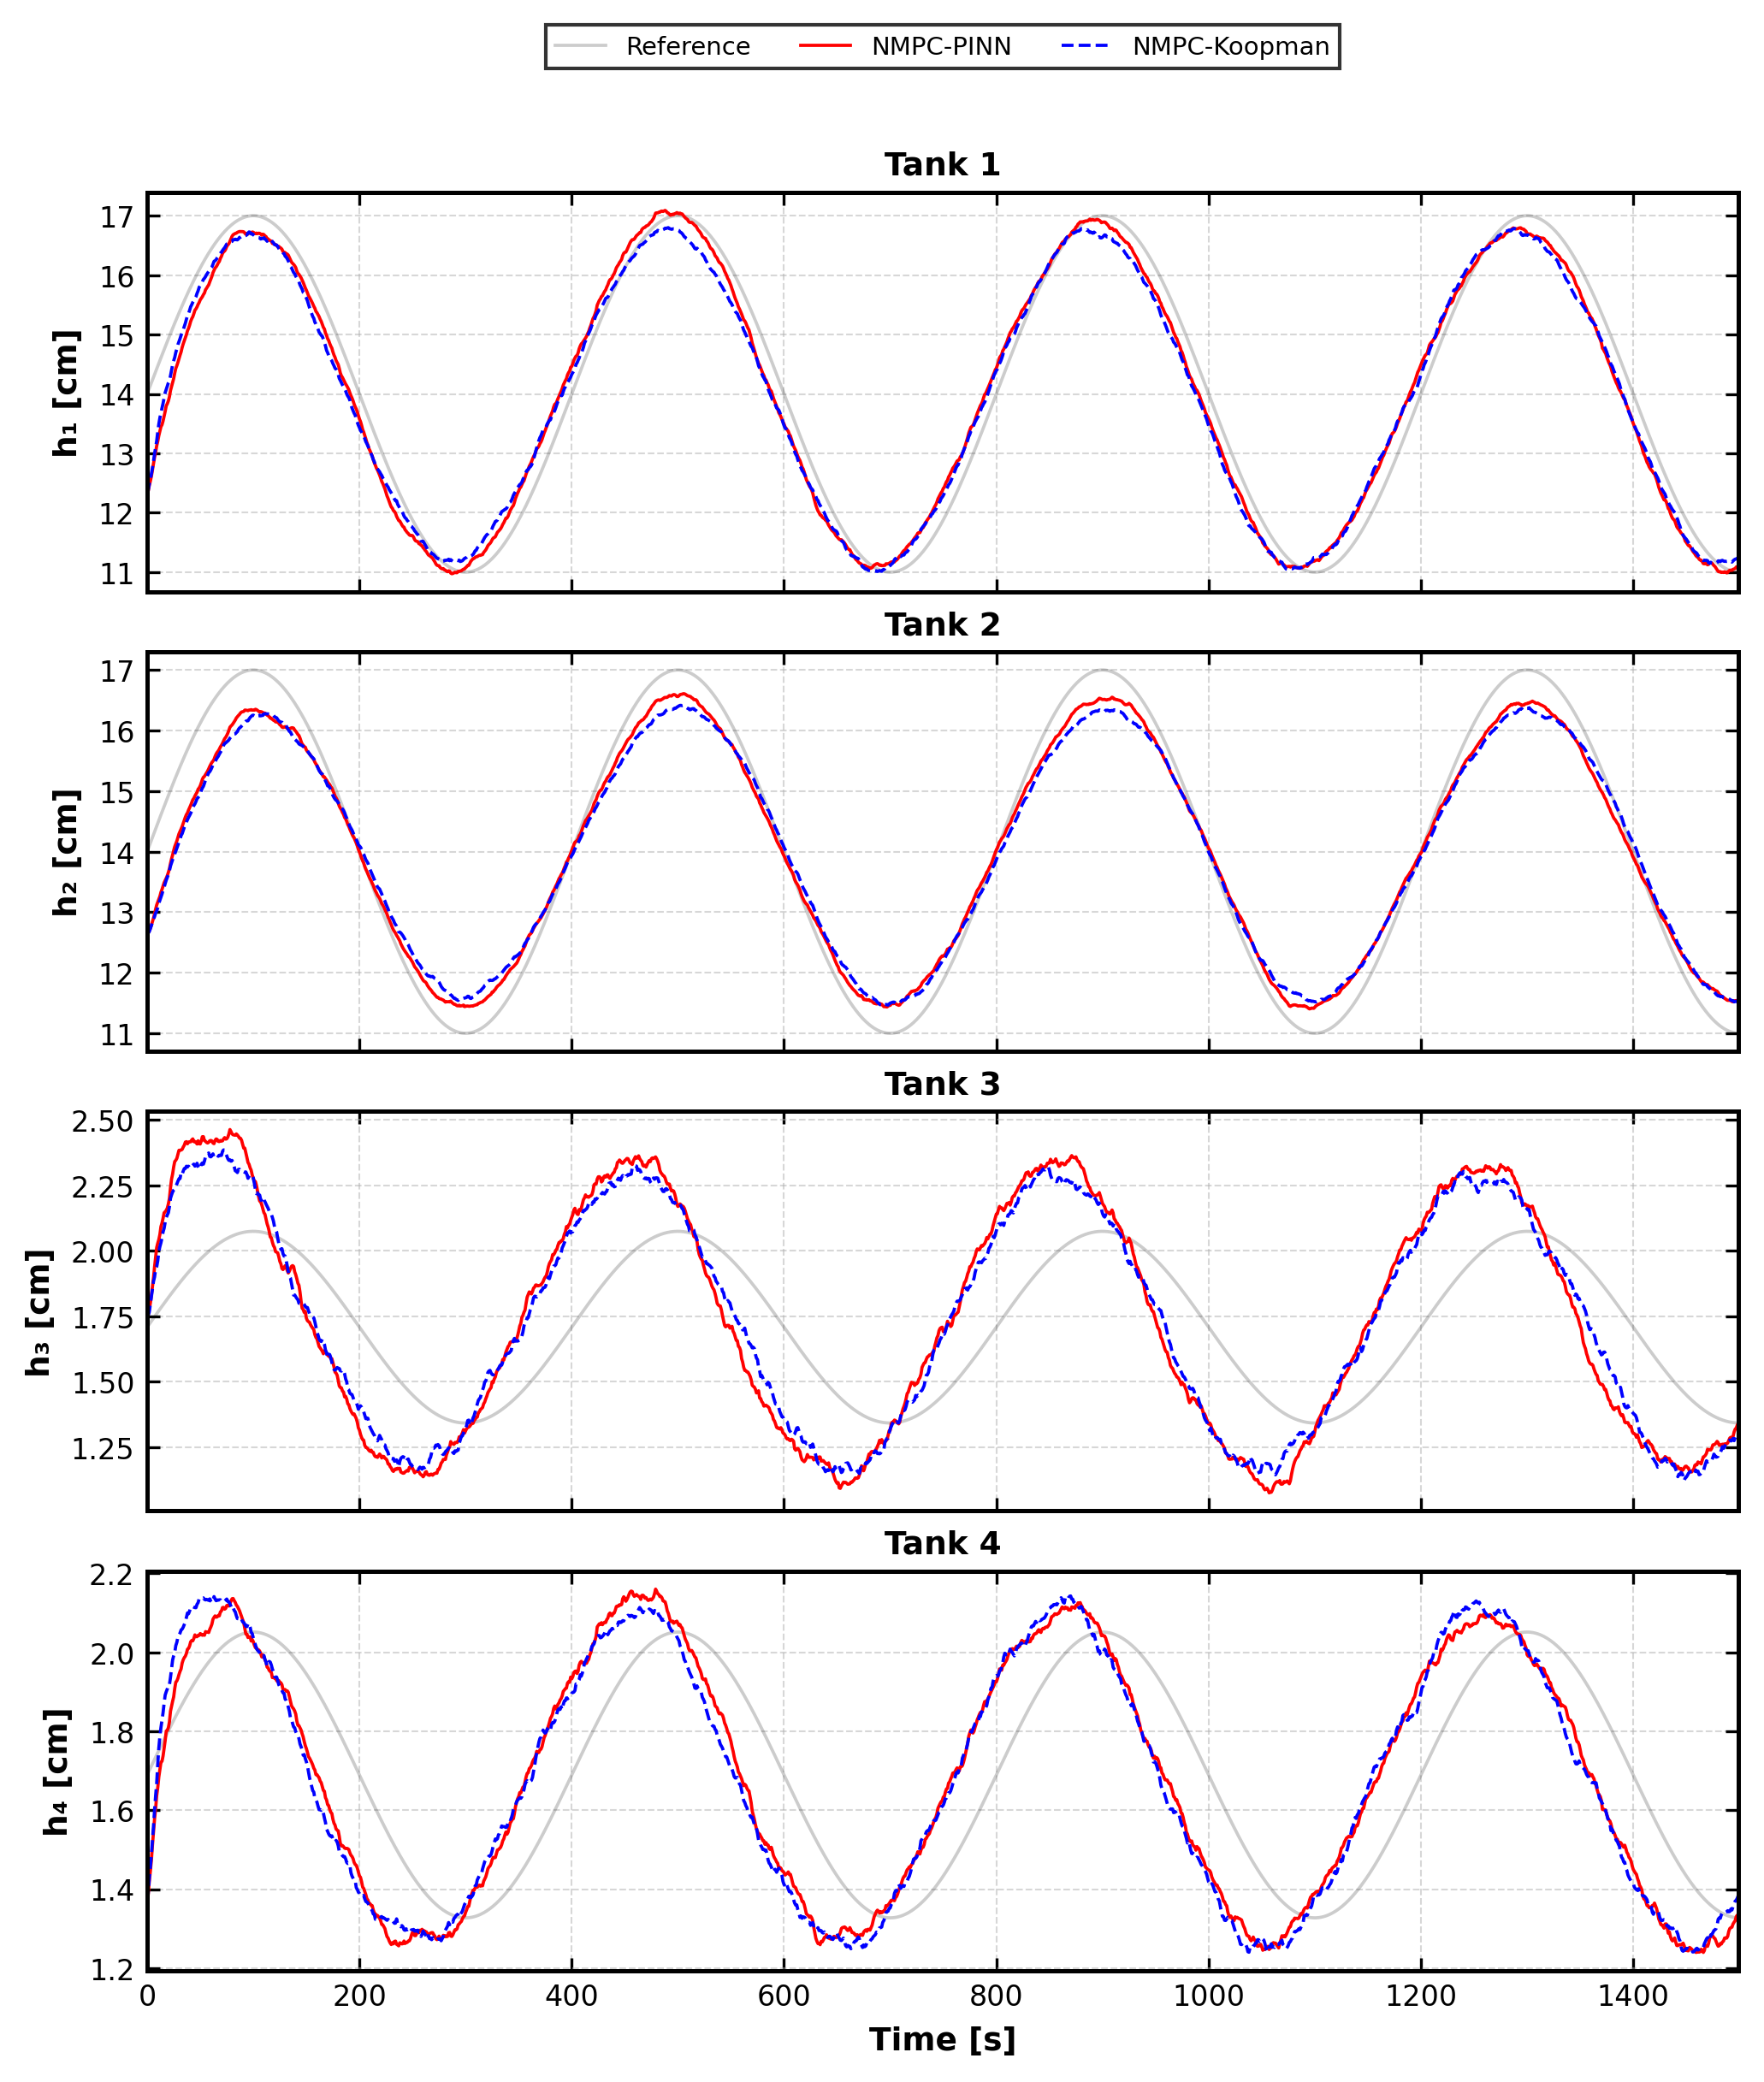

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. CARGA DE DATOS
df_edmd = pd.read_csv('control_lazo_cerrado_EDMD_sinusoidal.csv')
df_pinn = pd.read_csv('control_lazo_cerrado_PINN_sinusoidal.csv')

# 2. CONFIGURACIÓN ESTILO IEEE / BOX-ENCASED
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.linewidth": 1.2,      # Bordes de la caja más gruesos
    "legend.fontsize": 7,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "lines.linewidth": 1.1
})

# Formato vertical para estilo "Box" de paper
fig, axs = plt.subplots(4, 1, figsize=(8, 9), sharex=True, dpi=300)

# Definición de ventana de tiempo (ajusta según tus datos si es necesario)
t_start, t_end = df_edmd['Tiempo [s]'].min(), df_edmd['Tiempo [s]'].max()

config = [
    (0, 'Tank 1', 'h₁ [cm]', 'h1'),
    (1, 'Tank 2', 'h₂ [cm]', 'h2'),
    (2, 'Tank 3', 'h₃ [cm]', 'h3'),
    (3, 'Tank 4', 'h₄ [cm]', 'h4')
]

for i, title, ylabel, h_id in config:
    ax = axs[i]
    t = df_edmd['Tiempo [s]']

    # --- Graficar con estilos diferenciados ---
    # Referencia: Gris grueso de fondo
    ax.plot(t, df_edmd[f'{h_id}_Ref'],
            color='black', alpha=0.2, linewidth=0.9, label='Reference')

    # PINN: Rojo fino continuo (destaca por contraste)
    ax.plot(t, df_pinn[f'{h_id}_Real'],
            color='red', linestyle='-', linewidth=0.9, label='NMPC-PINN')

    # EDMD-Koopman: Azul discontinuo
    ax.plot(t, df_edmd[f'{h_id}_Real'],
            color='blue', linestyle='--', linewidth=0.9, label='NMPC-Koopman')

    # --- Formato de "Caja" ---
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, fontsize=9, fontweight='bold', pad=5)
    ax.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)
    ax.set_xlim(t_start, t_end)

    # Encapsulado: Asegurar que todos los bordes sean visibles
    for spine in ax.spines.values():
        spine.set_visible(True)

    # Ticks hacia adentro
    ax.tick_params(direction='in', top=True, right=True)

# Eje X final
axs[3].set_xlabel('Time [s]', fontweight='bold')

# Leyenda única organizada en la parte superior (estilo IEEE)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
              ncol=3, frameon=True, edgecolor='black', fancybox=False)

plt.subplots_adjust(hspace=0.15) # Espacio entre cajas
plt.savefig('control_sinusoidal_ieee_box.pdf', bbox_inches='tight')
plt.show()

In [37]:
import pandas as pd
import numpy as np

def calculate_metrics(real, ref):
    """Calcula el conjunto completo de métricas de desempeño"""
    error = real - ref
    mse = np.mean(error**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(error))
    sse = np.sum(error**2)

    # VAF: Variance After Filtering
    vaf = max(0, (1 - np.var(error) / np.var(ref))) * 100

    # NRMSE normalizado por el rango de la referencia
    rango = np.max(ref) - np.min(ref)
    nrmse = (rmse / rango) * 100 if rango != 0 else 0

    return {'RMSE': rmse, 'MAE': mae, 'VAF': vaf, 'NRMSE': nrmse, 'SSE': sse, 'MSE': mse}

# 1. CARGA DE DATOS DE LAZO CERRADO
df_edmd = pd.read_csv('control_lazo_cerrado_EDMD_cuadrada.csv')
df_pinn = pd.read_csv('control_lazo_cerrado_PINN_cuadrada.csv')

config_modelos = {
    'NMPC EDMD-Koopman': df_edmd,
    'NMPC PINN': df_pinn
}

final_results = {}

for model_name, df in config_modelos.items():
    tanks = {}
    for i in range(1, 5):
        h_id = f'h{i}'
        real = df[f'{h_id}_Real']
        ref = df[f'{h_id}_Ref']
        tanks[h_id] = calculate_metrics(real, ref)

    # Métricas Globales (Sistema completo)
    all_real = np.concatenate([df['h1_Real'], df['h2_Real'], df['h3_Real'], df['h4_Real']])
    all_ref = np.concatenate([df['h1_Ref'], df['h2_Ref'], df['h3_Ref'], df['h4_Ref']])

    global_m = calculate_metrics(all_real, all_ref)
    final_results[model_name] = {'Global': global_m, 'Tanks': tanks}

# 2. IMPRESIÓN FORMATEADA PARA ARTÍCULO
for model, data in final_results.items():
    print(f"\n{'='*65}")
    print(f" ANÁLISIS DE DESEMPEÑO: {model}")
    print(f"{'='*65}")

    # --- Métricas por Tanque (Simplificadas) ---
    print(f"{'Tanque':<8} | {'RMSE (cm)':<12} | {'MAE (cm)':<12} | {'VAF (%)':<10}")
    print(f"{'-'*50}")
    for t_id, m in data['Tanks'].items():
        print(f"{t_id.upper():<8} | {m['RMSE']:<12.4f} | {m['MAE']:<12.4f} | {m['VAF']:<10.2f}")

    print(f"{'-'*65}")

    # --- Métricas Globales (Exhaustivas con unidades) ---
    g = data['Global']
    print(f"📊 RESUMEN GLOBAL DEL SISTEMA:")
    print(f"  > RMSE  : {g['RMSE']:.4f} cm")
    print(f"  > MAE   : {g['MAE']:.4f} cm")
    print(f"  > VAF   : {g['VAF']:.2f} %")
    print(f"  > MSE   : {g['MSE']:.4f} cm²")
    print(f"  > SSE   : {g['SSE']:.2f} cm²")
    print(f"  > NRMSE : {g['NRMSE']:.2f} %")
    print(f"{'='*65}\n")


 ANÁLISIS DE DESEMPEÑO: NMPC EDMD-Koopman
Tanque   | RMSE (cm)    | MAE (cm)     | VAF (%)   
--------------------------------------------------
H1       | 0.6380       | 0.2963       | 91.24     
H2       | 0.7725       | 0.4535       | 87.54     
H3       | 0.2470       | 0.1323       | 81.42     
H4       | 0.1868       | 0.0880       | 89.26     
-----------------------------------------------------------------
📊 RESUMEN GLOBAL DEL SISTEMA:
  > RMSE  : 0.5243 cm
  > MAE   : 0.2425 cm
  > VAF   : 99.26 %
  > MSE   : 0.2749 cm²
  > SSE   : 1649.56 cm²
  > NRMSE : 3.49 %


 ANÁLISIS DE DESEMPEÑO: NMPC PINN
Tanque   | RMSE (cm)    | MAE (cm)     | VAF (%)   
--------------------------------------------------
H1       | 0.6388       | 0.2870       | 91.21     
H2       | 0.7371       | 0.4355       | 88.83     
H3       | 0.2482       | 0.1330       | 81.29     
H4       | 0.1869       | 0.0869       | 89.23     
-----------------------------------------------------------------
📊 RESUM

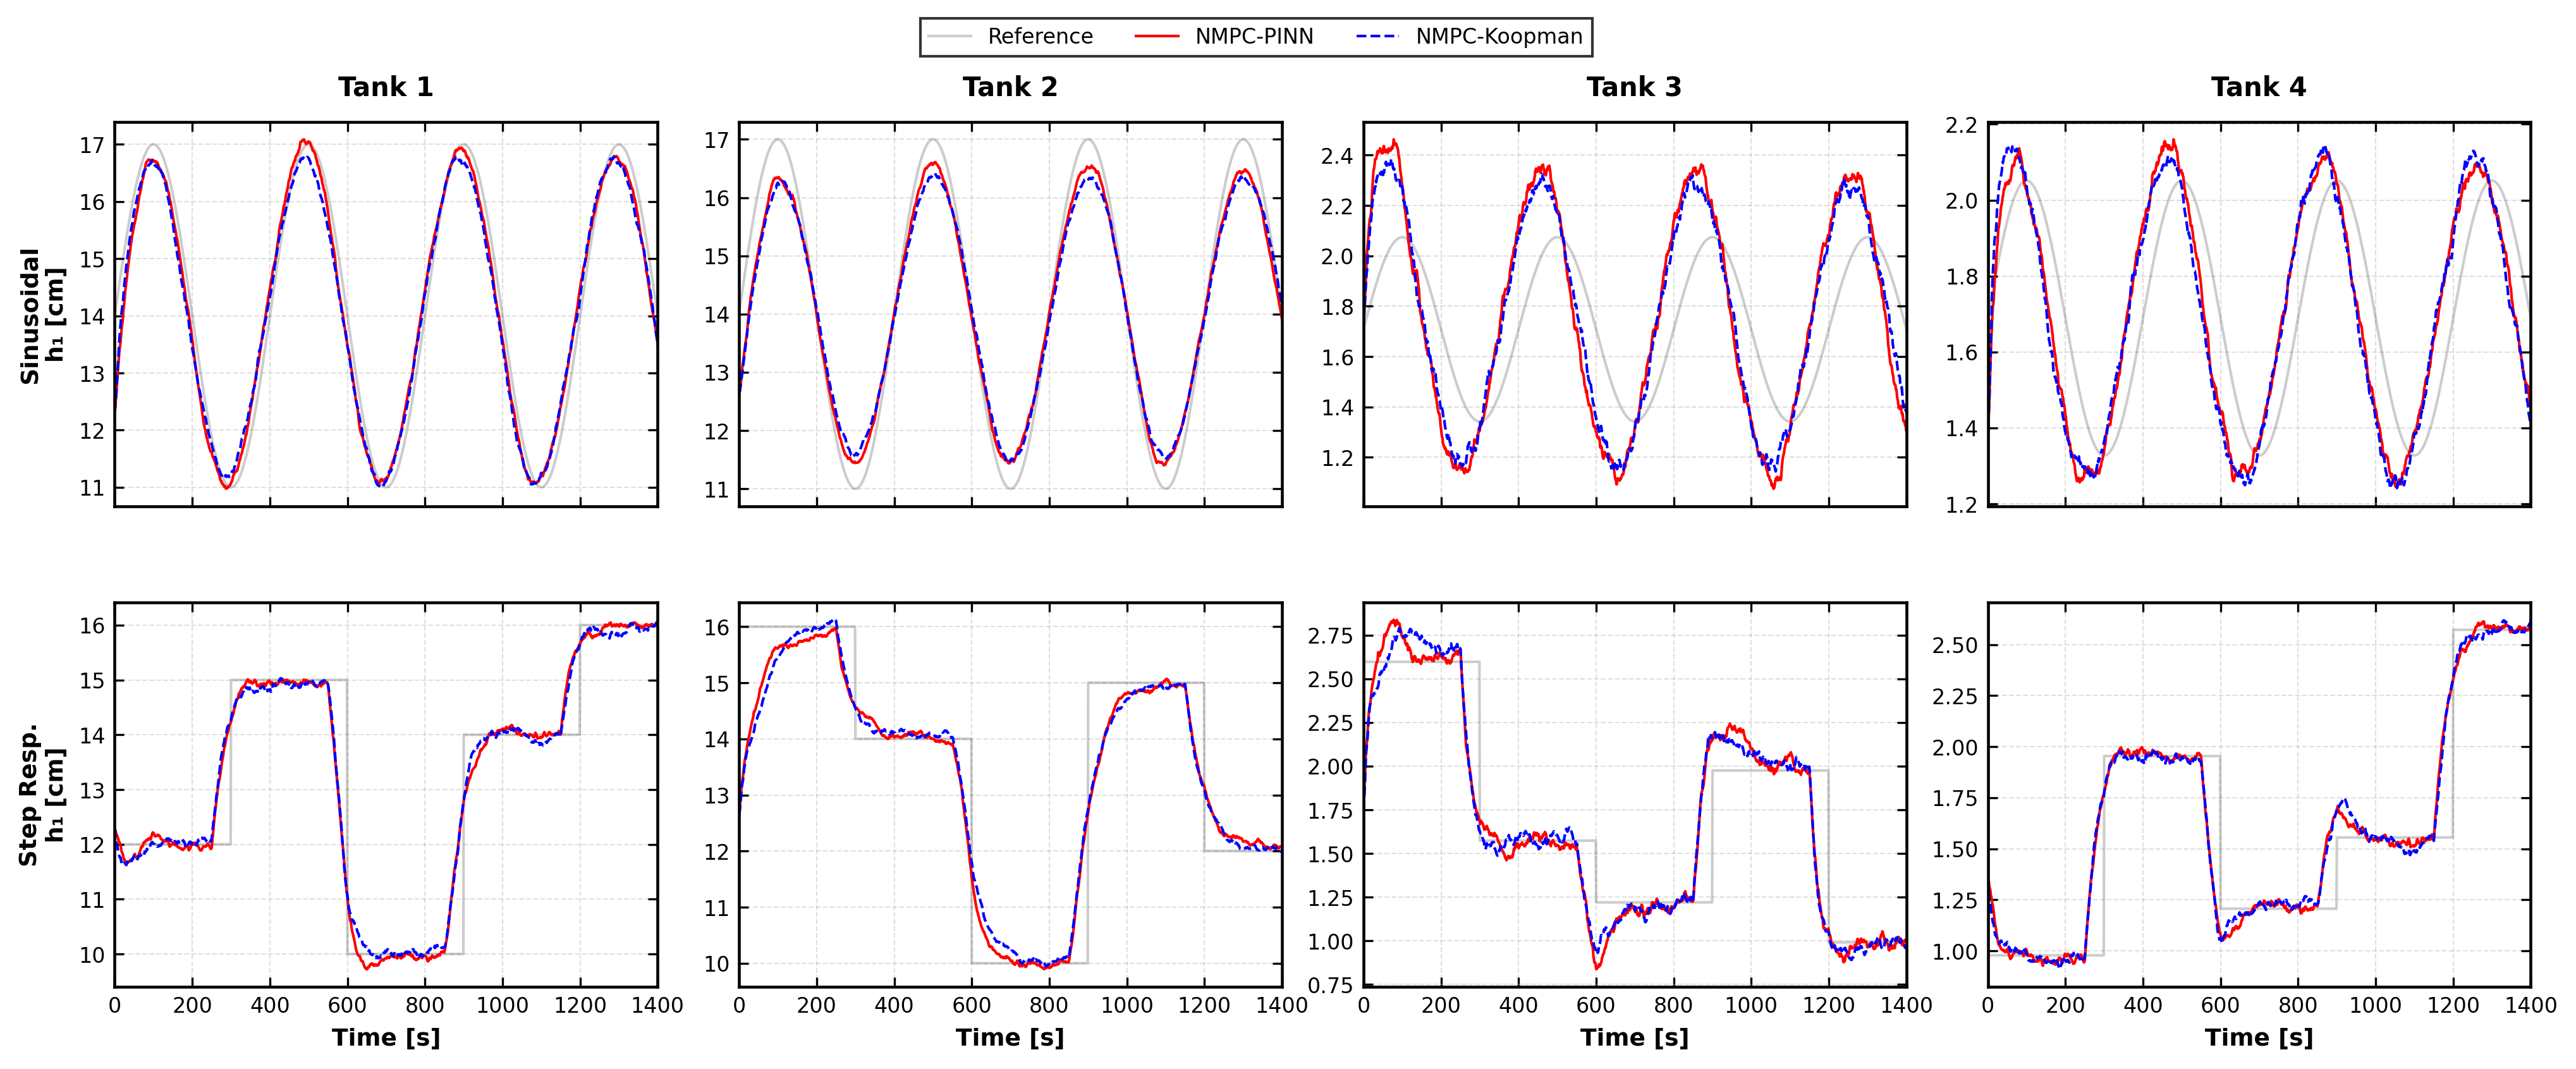

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. CARGA DE DATOS
df_edmd_s = pd.read_csv('control_lazo_cerrado_EDMD_sinusoidal.csv')
df_pinn_s = pd.read_csv('control_lazo_cerrado_PINN_sinusoidal.csv')
df_edmd_c = pd.read_csv('control_lazo_cerrado_EDMD_cuadrada.csv')
df_pinn_c = pd.read_csv('control_lazo_cerrado_PINN_cuadrada.csv')

# 2. CONFIGURACIÓN ESTILO IEEE
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.linewidth": 1.1,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "lines.linewidth": 1.0
})

# Cambiamos a 2 filas y 4 columnas. Ajustamos figsize para el ancho de página
fig, axs = plt.subplots(2, 4, figsize=(14, 6), sharex=True, dpi=300)

# Configuración: Mapeamos cada tanque a una columna (0 a 3)
# Estructura: (Columna, Nombre_Tanque, Etiqueta_Eje, ID_Datos)
config = [
    (0, 'Tank 1', 'h₁ [cm]', 'h1'),
    (1, 'Tank 2', 'h₂ [cm]', 'h2'),
    (2, 'Tank 3', 'h₃ [cm]', 'h3'),
    (3, 'Tank 4', 'h₄ [cm]', 'h4')
]

for col_idx, title, ylabel, h_id in config:
    # --- FILA 0: MIMO SINUSOIDAL ---
    ax0 = axs[0, col_idx]
    t_s = df_edmd_s['Tiempo [s]']
    ax0.plot(t_s, df_edmd_s[f'{h_id}_Ref'], color='black', alpha=0.2, label='Reference')
    ax0.plot(t_s, df_pinn_s[f'{h_id}_Real'], color='red', linestyle='-', label='NMPC-PINN')
    ax0.plot(t_s, df_edmd_s[f'{h_id}_Real'], color='blue', linestyle='--', label='NMPC-Koopman')
    ax0.set_title(title, fontsize=10, fontweight='bold', pad=10)

    # --- FILA 1: STEP RESPONSE ---
    ax1 = axs[1, col_idx]
    t_c = df_edmd_c['Tiempo [s]']
    ax1.plot(t_c, df_edmd_c[f'{h_id}_Ref'], color='black', alpha=0.2)
    ax1.plot(t_c, df_pinn_c[f'{h_id}_Real'], color='red', linestyle='-')
    ax1.plot(t_c, df_edmd_c[f'{h_id}_Real'], color='blue', linestyle='--')

    for ax in [ax0, ax1]:
        ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.5)
        ax.tick_params(direction='in', top=True, right=True)
        ax.set_xlim(0, 1400)

    # Solo ponemos el label del eje Y en la primera columna
    if col_idx == 0:
        ax0.set_ylabel('Sinusoidal\n' + ylabel, fontweight='bold')
        ax1.set_ylabel('Step Resp.\n' + ylabel, fontweight='bold')

    # Eje X en la fila de abajo
    ax1.set_xlabel('Time [s]', fontweight='bold')

# --- LEYENDA GLOBAL ---
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 0.98),
           ncol=3, frameon=True, edgecolor='black', fancybox=False)

# --- AJUSTE DE ESPACIOS ---
# wspace reducido para que las columnas estén juntas
plt.subplots_adjust(hspace=0.25, wspace=0.15, top=0.88, bottom=0.12, left=0.07, right=0.98)

plt.savefig('combined_control_results_2x4.pdf', bbox_inches='tight')
plt.show()